In [2]:
import pandas as pd
import numpy as np
from sklearn import cross_validation
import xgboost as xgb
import sklearn

In [4]:
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

## Функция для формирования посылки

In [5]:
from datetime import datetime, timedelta

# На вход подается массив размера (test.shape[0], 2)
def submit(preds):
    n = datetime.now() + timedelta(hours=3)
    submission = pd.read_csv('data/sample_submission.csv')
    submission['TARGET'] = preds[:, 1]
    submission.to_csv('submission ({0}).csv'.format(n.strftime("%d-%m-%Y %H:%M")), index=0)

## Загрузка данных

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

labels = train['TARGET']
train.drop(['TARGET', 'ID'], axis=1, inplace=1)
test.drop(['ID'], axis=1, inplace=1)

print train.shape
print test.shape

(76020, 369)
(75818, 369)


In [8]:
train.head(10)

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
5,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000
6,2,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000
7,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251638.950000
8,2,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101962.020000
9,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356463.060000


In [6]:
train.dtypes.value_counts()

int64      258
float64    111
dtype: int64

In [7]:
labels.value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

Классы несбалансированы

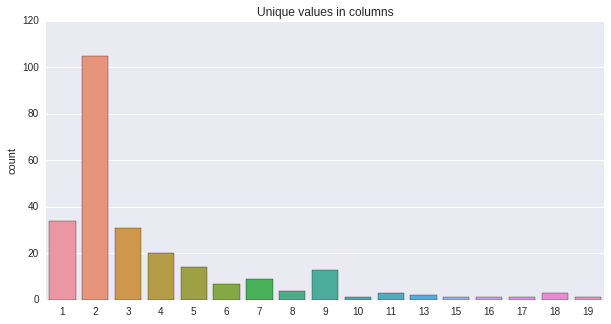

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(sorted([train[col].nunique() for col in train])[:250])
plt.title('Unique values in columns')

Примерно ~35 колонок содержат одно уникальное значение, поэтому их можно удалить

In [8]:
train.shape

(76020, 369)

In [9]:
test.shape

(75818, 369)

Можно заметить, что в данных очень много нулей. Посмотрим насколько много:

In [13]:
zeros_share = (train == 0).sum().sum() * 1. / np.prod(train.shape)
print 'Нулей: {0:0.2f}%'.format(100 * zeros_share)

Нулей: 89.98%


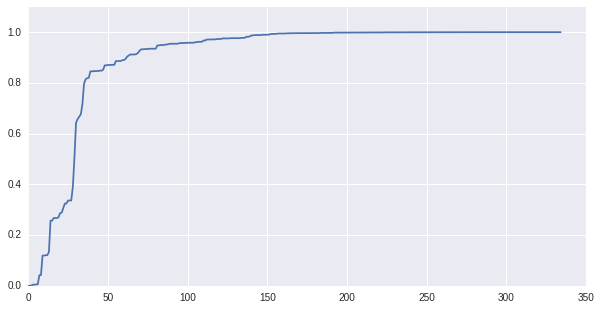

In [14]:
zero_counts = (train == 0).sum().sort_values() * 1. / train.shape[0]
plt.figure(figsize=(10, 5))
plt.plot(range(train.shape[1]), zero_counts.values)
_ = plt.ylim(0, 1.1)

Примерно в 2/3 колонок нулей больше 95%!

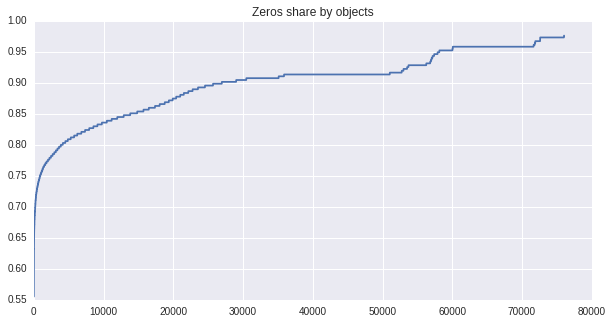

In [15]:
zeros_by_objects = (train == 0).sum(axis=1).sort_values() * 1. / train.shape[1]
plt.figure(figsize=(10, 5))
plt.plot(range(train.shape[0]), zeros_by_objects)
_ = plt.title('Zeros share by objects')

Почти во всех объектах нулей больше 75%, в половине - больше 90%. Так как у нас много признаков и они очень разреженные, то можно сделать вывод, что нули - это отсутствие информации о данном объекте. Например, человек никогда не брал вкладов и тогда признаки, отвечающие за вклады будут у него отсутствовать. Из этого можно извлечь информацию

In [7]:
unique_values = np.array([train[col].nunique() for col in train])
test.drop(train.columns[unique_values == 1], axis=1, inplace=1)
train.drop(train.columns[unique_values == 1], axis=1, inplace=1)

In [8]:
from itertools import combinations

features_duplicates = set()
visited_cols = set()

for col1 in train:
    visited_cols.add(col1)
    for col2 in train:
        if col2 in visited_cols or col2 in features_duplicates:
            continue
        if np.array_equal(train[col1], train[col2]):
            features_duplicates.add(col2)
            
print 'Дублирующихся признаков: {0}'.format(len(features_duplicates))

Дублирующихся признаков: 29


Оказывается среди коррелирующих признаков есть много дубликатов. Их можно удалить!

In [9]:
train.drop(features_duplicates, axis=1, inplace=1)
test.drop(features_duplicates, axis=1, inplace=1)

In [10]:
train.shape

(76020, 306)

## На признаки

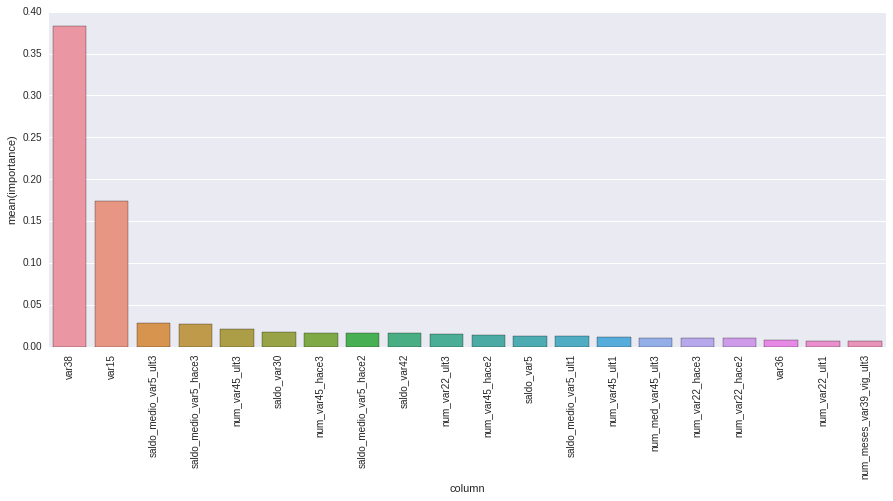

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(train, labels)
importances = pd.DataFrame({'column':train.columns, 'importance':rf.feature_importances_}).sort_values(by='importance', ascending=0)
plt.figure(figsize=(15, 6))
sns.barplot(x='column', y='importance', data=importances.iloc[:20])
_ = plt.xticks(rotation=90)


посмотрим на 2 самых важных признака

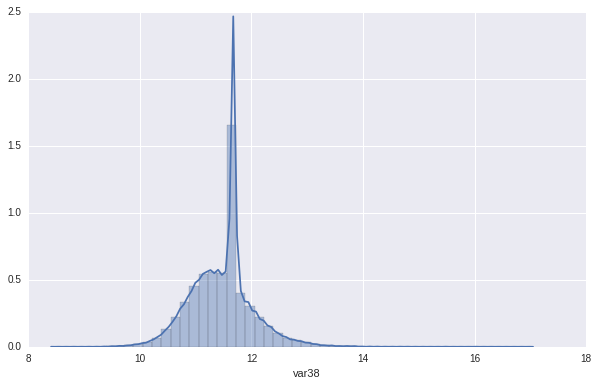

In [22]:
plt.figure(figsize=(10, 6))
sns.distplot(np.log1p(train['var38']))

## var38

In [10]:
train['var38'].value_counts().iloc[:10]

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
236690.340000        8
104644.410000        7
125722.440000        7
329603.970000        7
128318.520000        7
Name: var38, dtype: int64

Первое значение встречается подозрительно часто. Может быть это NaN, которые заменили на среднее? Проверим гипотезу

In [11]:
all = pd.concat([train, test])
mask = np.isclose(all['var38'], 117310.979, atol=1e-2)
all.loc[~mask, 'var38'].mean()

117310.979024098

Да, все сходится - организаторы конкурса заменили NaN в этой колонке на среднее. Из этого можно извлечь информацию - можно добавить фичу - is_var38_NaN

In [11]:
# var38mc == 1 when var38 has the most common value and 0 otherwise
# logvar38 is log transformed feature when var38mc is 0, zero otherwisetrain['var38mc'] = np.isclose(train.var38, 117310.979016)
train['var38mc'] = np.isclose(train.var38, 117310.979016)
train['logvar38'] = train.loc[~train['var38mc'], 'var38'].map(np.log)
train.loc[train['var38mc'], 'logvar38'] = 0

In [13]:
test['var38'].value_counts().iloc[:10]

117310.979016    14805
451931.220000       16
128318.520000       12
288997.440000       10
97639.560000         8
104040.180000        8
56021.610000         7
63203.340000         7
148736.190000        7
168733.620000        7
Name: var38, dtype: int64

In [12]:
test['var38mc'] = np.isclose(test.var38, 117310.979016)
test['logvar38'] = test.loc[~test['var38mc'], 'var38'].map(np.log)
test.loc[test['var38mc'], 'logvar38'] = 0

## var15

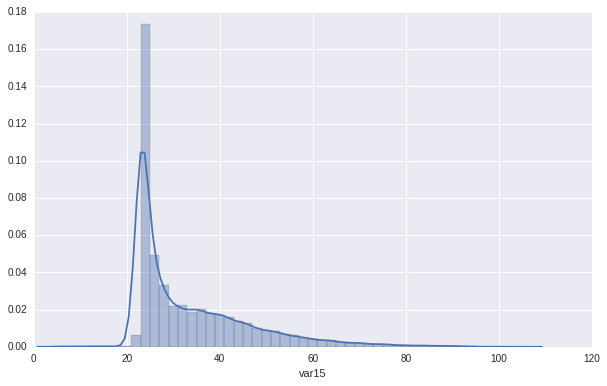

In [15]:

plt.figure(figsize=(10, 6))
sns.distplot(train['var15'])

Распределение очень напоминает возраст. Из этого тоже можно извлечь информацию - разделить по возрастным группам и т.д.

In [13]:

train.rename(columns={'var15': 'age'}, inplace=True)
test.rename(columns={'var15': 'age'}, inplace=True)


### var3 nationality of the customer

In [16]:
train.var3.value_counts() [:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

In [14]:
# Replace -999999 in var3 column with most common value 2 (because -99999 is NaN)
train = train.replace(-999999,2)
train.loc[train.var3==-999999].shape

(0, 308)

In [18]:
train.var3.value_counts()[:10]

2     74281
8       138
9       110
3       108
1       105
13       98
7        97
4        86
12       85
6        82
Name: var3, dtype: int64

In [19]:
test.var3.value_counts()[:10]

 2         73962
-999999      120
 8           116
 9           108
 3           107
 13          107
 1            99
 10           85
 11           85
 12           83
Name: var3, dtype: int64

In [15]:
test = test.replace(-999999,2)
test.loc[test.var3==-999999].shape

(0, 308)

### number of zeros in the row

In [16]:
train['n0'] = (train==0).sum(axis=1)

In [17]:
train[:3]

,var3,age,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,var38mc,logvar38,n0
0,2,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,39205.17,False,10.576564,293
1,2,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,49278.03,False,10.805234,267
2,2,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,67333.77,False,11.117417,278


In [18]:
test['n0'] = (test==0).sum(axis=1)

### saldo_var30

In [19]:
train['saldo_0'] = train['saldo_var30'].apply(lambda x:  x == 0 )
test['saldo_0'] = test['saldo_var30'].apply(lambda x:  x == 0 )

In [33]:
train[:2]

,var3,age,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,var38mc,logvar38,n0,log_saldo_var30
0,2,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,39205.17,False,10.576564,293,0.000000
1,2,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,49278.03,False,10.805234,267,5.703782


In [78]:
test[:1]

,var3,age,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,var38mc,logvar38,n0,log_saldo_var30,is_var36_99
0,2,32,0,0,0,0,0,0,0,0,...,0,0,0,0,40532.1,False,10.60985,276,1.791759,0


In [21]:
train['log_saldo_var30'] = train.loc[~train['saldo_0'], 'saldo_var30'].map(np.log)
train.loc[train['saldo_0'], 'log_saldo_var30'] = 0

In [22]:
test['log_saldo_var30'] = test.loc[~test['saldo_0'], 'saldo_var30'].map(np.log)
test.loc[test['saldo_0'], 'log_saldo_var30'] = 0

In [23]:
train.drop('saldo_0',axis=1, inplace=True)
test.drop('saldo_0',axis=1, inplace=True)


In [33]:
train.shape


(76020, 310)

In [25]:
train['log_saldo_var30'].value_counts()

 0.000000     20310
 1.098612     18290
 4.499810      5236
 3.401197      1603
 2.708050      1477
 1.791759       926
 5.010635       823
 4.094345       686
 5.703782       400
 4.787492       305
 4.532599       196
 2.197225       153
 6.396930       149
 6.802395       137
 6.109248       115
 5.030438       104
 3.806662        97
 5.192957        96
 7.313220        92
 8.006368        91
 2.484907        84
 0.405465        73
 11.407565       71
-1.203973        68
 11.918391       65
 12.611538       65
 5.713733        65
 11.002100       61
 10.308953       59
 6.620073        58
              ...  
 12.110138        1
 9.959842         1
 9.755567         1
 6.565490         1
 7.030088         1
 11.695876        1
 6.113040         1
 7.450004         1
 7.073236         1
 4.072610         1
 11.837549        1
 11.887510        1
 7.328523         1
 8.694944         1
 7.124188         1
 5.115716         1
 7.896754         1
 4.570889         1
 6.742114         1


In [32]:
test.shape

(75818, 310)

## var36

In [30]:
train['var36'].value_counts()

99    30064
3     22177
1     14664
2      8704
0       411
Name: var36, dtype: int64

In [31]:
test['var36'].value_counts()


99    30095
3     22216
1     14368
2      8768
0       371
Name: var36, dtype: int64

In [34]:
#'If var36 is 0,1,2 or 3 => less unhappy customers'
set(train['var36'])

{0, 1, 2, 3, 99}

### num_var5

In [44]:
train['num_var5'].value_counts()

3     50265
0     25561
6       190
9         3
15        1
Name: num_var5, dtype: int64

In [ ]:
test['is_var36_99'] = test['var36'].apply(lambda x: int( x == 99 ))

In [32]:
train['log_saldo_var30'].isnull().sum()

120

In [96]:
train.drop('log_saldo_var30', axis=1,inplace=True)
test.drop('log_saldo_var30', axis=1,inplace=True)


## ROC_AUC

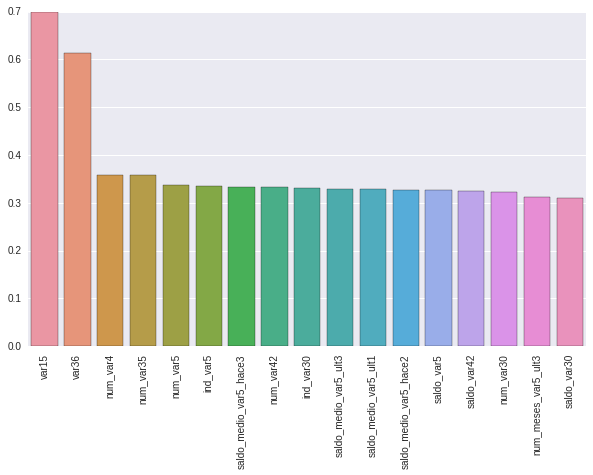

In [57]:
from sklearn.metrics import roc_auc_score

scores = []

for column in train:
    roc_score = roc_auc_score(labels, train[column])
    if abs(roc_score - 0.5) > 0.1:
        scores.append((column, roc_score))
scores = sorted(scores, key=lambda x: x[1], reverse=1)

plt.figure(figsize=(10, 6))
sns.barplot(*zip(*scores))
_ = plt.xticks(rotation=90)

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
cv = StratifiedKFold(labels, n_folds=3)
print cross_val_score(rf, train, labels, scoring='roc_auc', cv=cv).mean()

0.755026049807


In [98]:
rf.fit(train, labels)
preds = rf.predict_proba(test)
submit(preds)

In [103]:
X_train, X_test, y_train, y_test = \
  cross_validation.train_test_split(train, labels, random_state=1301, stratify=labels, test_size=0.4)

In [27]:
ratio = float(np.sum(labels == 1)) / np.sum(labels==0)

In [30]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold

cv = StratifiedKFold(labels, n_folds=3)
print cross_val_score(clf, train, labels, scoring='roc_auc', cv=cv).mean()

XGBoostError: There are NAN in the matrix, however, you did not set missing=NAN

In [ ]:
def xgb_predict(train,test,labels):
    params = {}
    params['max_depth'] = 5
    params['n_estimators']=1000
    params['learning_rate']=0.1 
    params['nthread']=4
    params['subsample']=1.0
    params['colsample_bytree']=0.5
    params['min_child_weight'] = 3
    params['scale_pos_weight'] = ratio
    params['reg_alpha']=0.03
    params['seed']=1301
    params['gamma'] = 15
    params['scale_pos_weight']
    
    

In [29]:
from sklearn.metrics import roc_auc_score


clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 5,
                n_estimators=1000,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                scale_pos_weight = ratio,
                reg_alpha=0.03,
                seed=1301)

In [ ]:
train['log_saldo']

In [114]:
from sklearn.metrics import roc_auc_score
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 5,
                n_estimators=1000,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                scale_pos_weight = ratio,
                reg_alpha=0.03,
                seed=1301)
                
clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc",
        eval_set=[(X_train, y_train), (X_test, y_test)])
        
print('Overall AUC:', roc_auc_score(labels, clf.predict_proba(train, ntree_limit=clf.best_iteration)[:,1]))

Will train until validation_1 error hasn't decreased in 50 rounds.
[0]	validation_0-auc:0.500000	validation_1-auc:0.500000
[1]	validation_0-auc:0.500000	validation_1-auc:0.500000
[2]	validation_0-auc:0.500000	validation_1-auc:0.500000
[3]	validation_0-auc:0.500000	validation_1-auc:0.500000
[4]	validation_0-auc:0.500000	validation_1-auc:0.500000
[5]	validation_0-auc:0.500000	validation_1-auc:0.500000
[6]	validation_0-auc:0.500000	validation_1-auc:0.500000
[7]	validation_0-auc:0.500000	validation_1-auc:0.500000
[8]	validation_0-auc:0.500000	validation_1-auc:0.500000
[9]	validation_0-auc:0.500000	validation_1-auc:0.500000
[10]	validation_0-auc:0.500000	validation_1-auc:0.500000
[11]	validation_0-auc:0.500000	validation_1-auc:0.500000
[12]	validation_0-auc:0.500000	validation_1-auc:0.500000
[13]	validation_0-auc:0.500000	validation_1-auc:0.500000
[14]	validation_0-auc:0.500000	validation_1-auc:0.500000
[15]	validation_0-auc:0.500000	validation_1-auc:0.500000
[16]	validation_0-auc:0.500000	

('Overall AUC:', 0.85484214522882274)


Stopping. Best iteration:
[316]	validation_0-auc:0.863006	validation_1-auc:0.842645



In [116]:
y_pred = clf.predict_proba(test, ntree_limit=clf.best_iteration)

In [111]:
submit(y_pred)